# PAMAP2 ➜ TS2Vec ➜ Fractal‑SSL  
An interactive, step‑by‑step Jupyter workflow.

**Sections**
1. Inspect & preprocess PAMAP2
2. Pre‑train a TS2Vec backbone
3. Enhance with Fractal‑SSL


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0  Setup

In [2]:
#  Run once per environment
!pip install -q torch==2.3.0 ts2vec pandas scikit-learn tqdm


ERROR: Operation cancelled by user
^C


KeyboardInterrupt: 

## 1  Imports & paths

In [2]:
import os, glob, json, math, random, itertools, pickle
from pathlib import Path
import numpy as np, pandas as pd, torch
from tqdm import tqdm

from ts2vec import TS2Vec
import random
RAW_ROOT   = Path('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset').expanduser()   # <- edit if needed
CACHE_ROOT = Path('/content/drive/MyDrive/FractalSSL_backup/cache')
CACHE_ROOT.mkdir(exist_ok=True)

SEED = 42;
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [138]:

RAW_ROOT

PosixPath('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset')

### Helper to read a single PAMAP2 `.dat` file

In [139]:
from sklearn.preprocessing import RobustScaler, StandardScaler
COLS = [
    "timestamp", "activity_id", "heart_rate",
    # IMU columns...
]  # shortened for brevity – full list in spec

WIN  = 256        # 2.56 s @100 Hz
STEP = 256        # non-overlapping

def clean_pamap_df(df, drop_na_thresh=0.9):
    df = df.copy()
    # 1) heart-rate sentinel −1  → NaN → interpolate
    if 'heart_rate' in df.columns:
        df['heart_rate'].replace(-1, np.nan, inplace=True)
        df['heart_rate'].interpolate("linear", limit_direction="both", inplace=True)

    # 2) drop channels with too many NaNs (often IMU orientation)
    bad = df.columns[df.isna().mean() > drop_na_thresh]
    df.drop(columns=bad, inplace=True)

    # 3) fill residual gaps
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    df.fillna(0.0, inplace=True)

    return df.astype("float32")


def load_dat(path: Path, cols=COLS):
    """Read raw .dat → DataFrame (no NaNs, z-scored sensor channels)."""
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = cols + [f'col_{i}' for i in range(len(df.columns)-len(cols))]

    df = clean_pamap_df(df)                       # <<< NEW

    # z-score *after* gaps are filled
    sensor_cols = df.columns.drop(['timestamp', 'activity_id'])

    # split: robust for HR, standard for the rest
    hr_col = ['heart_rate']
    other_cols = [c for c in sensor_cols if c not in hr_col]

    df[hr_col] = RobustScaler(with_centering=True, with_scaling=True,
                              quantile_range=(15, 85)).fit_transform(df[hr_col])

    scaler = StandardScaler(with_mean=True, with_std=True)
    other_scaled = scaler.fit_transform(df[other_cols])

    # std()=0 guard happens inside StandardScaler, so no new NaNs
    df[other_cols] = other_scaled.astype(np.float32)
    return df





In [142]:
RAW_ROOT.glob("subject*.dat")

<generator object Path.glob at 0x7907c32f8bf0>

In [144]:
def window_iter(df, win=WIN, step=STEP):
    for s in range(0, len(df) - win + 1, step):
        yield df.iloc[s:s+win].to_numpy(dtype=np.float32)

CACHE_ROOT.mkdir(exist_ok=True, parents=True)
for dat in tqdm(RAW_ROOT.rglob('*.dat'), desc="caching"):
    subj = dat.stem
    print(subj)                     # 'subject101'
    out  = CACHE_ROOT / f"{subj}.pkl"
    if out.exists():                         # skip if already clean
        continue
    df   = load_dat(dat)                     # your cleaner + scaling
    # -------- convert to window list ----------------------------------------
    wins = np.stack(list(window_iter(df.drop(columns=["timestamp",
                                                      "activity_id"]))))
    labels = np.array([np.bincount(df["activity_id"]
                    .iloc[s:s+WIN].astype("int32")).argmax()
                       for s in range(0, len(df) - WIN + 1, STEP)],
                      dtype=np.int64)
    # save BOTH windows and labels in one dict
    pickle.dump({"X": wins, "y": labels, "subj": subj}, open(out, "wb"))
print("✅ cache rebuilt")

caching: 0it [00:00, ?it/s]

subject101


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject102


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject103


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject104


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject105


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject106


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject107


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject108


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

subject109
subject101
subject105
subject106
subject108
subject109
✅ cache rebuilt


### Load & peek at Subject 101

In [145]:
print('First 5 .dat files I see:')
for p in list(RAW_ROOT.rglob('*.dat'))[:5]:
    print(' •', p.relative_to(RAW_ROOT))

First 5 .dat files I see:
 • Protocol/subject101.dat
 • Protocol/subject102.dat
 • Protocol/subject103.dat
 • Protocol/subject104.dat
 • Protocol/subject105.dat


In [146]:
sample_path = next(RAW_ROOT.glob('*Protocol/subject101.dat'))
df101 = load_dat(sample_path)
df101.head()


/tmp/ipython-input-139-3542146686.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-139-3542146686.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

,timestamp,activity_id,heart_rate,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,8.38,0.0,-0.428571,-1.963841,0.898792,0.447002,0.031486,0.895948,0.471187,-0.063455,...,0.009056,0.014038,-0.017178,-0.400685,-1.137237,-2.325001,0.0,0.0,0.0,0.0
1,8.39,0.0,-0.428571,-1.963841,0.869938,0.440238,0.076209,0.888981,0.430768,0.021841,...,-0.005863,-0.008964,-0.007136,-0.348521,-1.135016,-2.337929,0.0,0.0,0.0,0.0
2,8.40,0.0,-0.428571,-1.963841,0.899003,0.447065,0.042866,0.874955,0.428014,0.048767,...,0.003755,-0.001037,0.005244,-0.383074,-1.152067,-2.333679,0.0,0.0,0.0,0.0
3,8.41,0.0,-0.428571,-1.963841,0.852104,0.433103,0.075742,0.879663,0.427971,0.048758,...,0.003917,-0.034904,-0.001033,-0.370353,-1.130820,-2.333534,0.0,0.0,0.0,0.0
4,8.42,0.0,-0.428571,-1.963841,0.876371,0.491362,0.087503,0.863305,0.439702,0.057714,...,0.013466,-0.024970,-0.008921,-0.413566,-1.151221,-2.329257,0.0,0.0,0.0,0.0


### Cache all subjects (optional, ~1 GB)

## 2  TS2Vec pre‑training

In [ ]:
%pip uninstall -y ts2vec
%pip install git+https://github.com/yuezhihan/ts2vec.git@main


Found existing installation: ts2vec 0.1
Uninstalling ts2vec-0.1:
  Successfully uninstalled ts2vec-0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/yuezhihan/ts2vec.git (to revision main) to /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Running command git clone --filter=blob:none --quiet https://github.com/yuezhihan/ts2vec.git /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Resolved https://github.com/yuezhihan/ts2vec.git to commit b0088e14a99706c05451316dc6db8d3da9351163
ERROR: git+https://github.com/yuezhihan/ts2vec.git@main does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install ts2vec

  Using cached ts2vec-0.1-py3-none-any.whl.metadata (53 bytes)
Using cached ts2vec-0.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
from torch.utils.data import Dataset
class PAMAP2Windows(Dataset):
    """Returns windows + labels + subject-id, all from the new cache."""
    def __init__(self, cache_root=CACHE_ROOT, with_labels=True):
        self.X, self.y, self.groups = [], [], []
        for pkl in cache_root.glob("subject*.pkl"):
            obj = pickle.load(open(pkl, "rb"))
            self.X.append(obj["X"])
            self.groups += [obj["subj"]] * len(obj["X"])
            if with_labels:
                self.y.append(obj["y"])
        self.X = np.concatenate(self.X)
        self.groups = np.array(self.groups)
        if with_labels:
            self.y = np.concatenate(self.y)
        else:                               # SSL needs no labels
            self.y = None

    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx])
        if self.y is not None:
            return x, self.y[idx], self.groups[idx]
        return x, self.groups[idx]



In [5]:
from sklearn.model_selection import GroupShuffleSplit

import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def stratified_group_split(X, y, groups, test_size=0.2, seed=42, max_trials=1_000):
    """Return idx_train, idx_test such that every class appears in train."""
    rs = np.random.RandomState(seed)
    all_classes = np.unique(y)

    for _ in range(max_trials):
        random_state = rs.randint(0, 10_000_000)
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size,
                                random_state=random_state)
        tr_idx, te_idx = next(gss.split(X, y, groups=groups))
        if np.all(np.isin(all_classes, y[tr_idx])):      # every class present?
            return tr_idx, te_idx

    raise RuntimeError("Could not find a split with all classes in train")

# ---------------------------------------------------------------------------
ds = PAMAP2Windows(with_labels=True)         # unified cache
tr_idx, te_idx = stratified_group_split(ds.X, ds.y, ds.groups,
                                             test_size=0.2, seed=42)


# keep indices for everything that follows
save_path_train = '/content/drive/MyDrive/FractalSSL_backup/models/train_idx.npy'
save_path_test = '/content/drive/MyDrive/FractalSSL_backup/models/test_idx.npy'
np.save(save_path_train, tr_idx); np.save(save_path_test, te_idx)


In [170]:
del full_ds
gc.collect()

15940

In [6]:
import torch
#torch.backends.mps.is_available()
# → True  on mac
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'


# Colab → use the CUDA device if the notebook is attached to a GPU runtime,
# otherwise fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)



Using device: cuda


In [7]:
from torch.utils.data import Subset, DataLoader
# OPTIONAL: if RAM is tight, feed a DataLoader directly -------------
train_loader = DataLoader(
    Subset(ds, tr_idx), batch_size=256, shuffle=True, drop_last=True
)
train_windows =ds.X[tr_idx].astype(np.float32)

In [8]:
train_windows

array([[[-0.42857143, -1.9638411 ,  0.8987924 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.86993796, ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.8990027 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.38404456, -1.9133081 ,  0.95738494, ...,  0.        ,
          0.        ,  0.        ],
        [-0.3821892 , -1.9133081 ,  0.947286  , ...,  0.        ,
          0.        ,  0.        ],
        [-0.38033387, -1.9133081 ,  0.9662942 , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.3784787 , -1.9133081 ,  0.94274116, ...,  0.        ,
          0.        ,  0.        ],
        [-0.37662336, -1.9133081 ,  0.96469975, ...,  0.        ,
          0.        ,  0.        ],
        [-0.37476817, -1.9133081 ,  0.9593576 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.40816328, -1.9133081 ,  0.8132789 , ...,  

In [9]:
assert set(ds.groups[tr_idx]) & set(ds.groups[te_idx]) == set()
assert set(np.unique(ds.y[tr_idx])) == set(np.unique(ds.y))   # full coverage


In [176]:
# clean ram
del ds
gc.collect()

8

In [10]:
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,   # hyper-params live in the constructor
    lr=1e-3
)

enc.fit(train_windows, n_epochs=20, verbose=True)
enc.save('ts2vec_backbone.pt')


Epoch #0: loss=6.650600263050625
Epoch #1: loss=3.3699443749019076
Epoch #2: loss=2.9563294070107595
Epoch #3: loss=2.67618043082101
Epoch #4: loss=2.4165271759033202
Epoch #5: loss=2.1342828171593804
Epoch #6: loss=1.925367638042995
Epoch #7: loss=1.741604130608695
Epoch #8: loss=1.690030802999224
Epoch #9: loss=1.5346286637442452
Epoch #10: loss=1.4958811283111573
Epoch #11: loss=1.4699169363294329
Epoch #12: loss=1.394549867085048
Epoch #13: loss=1.2651228359767368
Epoch #14: loss=1.2098882232393537
Epoch #15: loss=1.148821006502424
Epoch #16: loss=1.1728482382638115
Epoch #17: loss=1.0361576216561454
Epoch #18: loss=1.0697606120790755
Epoch #19: loss=1.0222064563206263


In [11]:
# save the backbone for later use
save_path = '/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt'
enc.save(save_path)


In [12]:
# load the backbone
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,
    lr=1e-3
)
enc.load('/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt')

/usr/local/lib/python3.11/dist-packages/ts2vec/ts2vec.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fn, map_location=self.device)


In [13]:
# one dataset serves SSL & probe
full_ds = PAMAP2Windows(with_labels=True)          # uses CACHE_ROOT
print("All windows :", len(full_ds), full_ds.X.shape)   # (N,256,C) float32


All windows : 11216 (11216, 256, 52)


In [14]:
train_idx = np.load(save_path_train)               # from the GroupShuffleSplit step
test_idx  = np.load(save_path_test)

X_tr, y_tr = full_ds.X[train_idx], full_ds.y[train_idx]
X_te, y_te = full_ds.X[test_idx],  full_ds.y[test_idx]


In [15]:
with torch.no_grad():

    feats_tr = enc.encode(X_tr.astype(np.float32))    # (Ntrain, 256, D)
    Z_tr  = feats_tr[:, -1, :]                        # take last timestep
    feats_ts = enc.encode(X_te.astype(np.float32))
    Z_te  = feats_ts[:, -1, :]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(Z_tr, y_tr)

pred = clf.predict(Z_te)
print(classification_report(y_te, pred, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.661     0.620     0.640       623
           1      1.000     0.930     0.964       186
           2      0.630     0.925     0.749       160
           3      0.823     0.750     0.785       180
           4      0.812     0.722     0.765       245
           5      0.412     0.538     0.467        13
           6      0.920     0.910     0.915        89
           7      0.381     0.571     0.457       112
          12      0.557     0.536     0.546       110
          13      0.667     0.519     0.584       104
          16      0.839     0.736     0.784       163
          17      0.874     0.858     0.866       226
          24      0.000     0.000     0.000         0

    accuracy                          0.723      2211
   macro avg      0.660     0.663     0.656      2211
weighted avg      0.742     0.723     0.728      2211



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


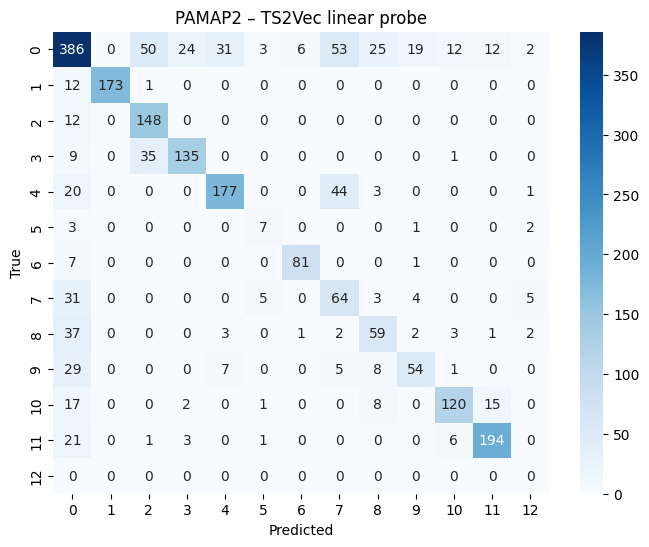

In [17]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


In [18]:
classes = np.unique(y_tr)
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24])

## 3  Fractal‑SSL fine‑tuning

In [19]:
class FractalViewGenerator:
    """Produces recursively smaller crops of the same window."""
    def __init__(self, levels=4):
        self.levels = levels
    def __call__(self, ts):
        L = ts.shape[0]
        views = []
        for i in range(self.levels):
            frac = 1 / (2 ** i)
            win = int(L * frac)
            start = random.randint(0, L - win)
            views.append(ts[start:start+win])
        return views
gen = FractalViewGenerator(levels=4)

ts = torch.from_numpy(X_tr[0])     # one window, shape (L, C)
views = gen(ts)                          # list of 4 tensors

print([v.shape for v in views])


[torch.Size([256, 52]), torch.Size([128, 52]), torch.Size([64, 52]), torch.Size([32, 52])]


In [20]:
def nt_xent(reps: torch.Tensor, batch_size: int, n_views: int, T: float) -> torch.Tensor:
    """
    reps      : (B * n_views, D) ℓ2-normalised
    returns   : scalar loss
    """
    N   = reps.size(0)
    sim = reps @ reps.T / T                       # cosine sim over temperature

    # zero out self-similarities (i == j)
    sim.fill_diagonal_(-1e4)

    # positive index: for each view i, its twin is (i ± 1) within the same sample
    view_idx   = torch.arange(N, device=reps.device)
    pos_index  = view_idx ^ 1                     # flips last bit: 0↔1, 2↔3, …
    loss       = torch.nn.functional.cross_entropy(sim, pos_index)

    return loss


In [21]:
import torch, random, numpy as np
from typing import List, Tuple

class FractalViewGenerator:
    def __init__(self, levels: int = 4):
        self.levels = levels
    def __call__(self, ts: torch.Tensor) -> Tuple[List[torch.Tensor], List[int]]:
        L, views, lens = ts.size(0), [], []
        for i in range(self.levels):
            win   = int(L / 2 ** i)
            start = random.randint(0, L - win)
            crop  = ts[start:start + win]
            views.append(crop)
            lens.append(win)
        return views, lens

class FractalSSL(torch.nn.Module):
    def __init__(self, backbone, proj_dim=128, levels=4,
                 temperature=0.1, freeze_backbone=True):
        super().__init__()
        self.backbone, self.levels, self.temperature = backbone, levels, temperature
        self.view_gen = FractalViewGenerator(levels)

        # ---- determine channels & device from first param -------------------
        first_w  = next(backbone.net.parameters()) if hasattr(backbone, "net") \
                   else next(backbone.parameters())
        self._in_channels = first_w.shape[1] if first_w.ndim >= 2 else first_w.shape[0]

        # ---- optional freezing ---------------------------------------------
        if freeze_backbone and hasattr(backbone, "net"):
            for p in backbone.net.parameters():
                p.requires_grad = False

        # ---- infer latent dimension ----------------------------------------
        with torch.no_grad():
            dummy = np.zeros((1, 8, self._in_channels), dtype='float32')
            latent_dim = backbone.encode(dummy).shape[-1]

        self.proj = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, proj_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(proj_dim, proj_dim)
        )

    # ---------- tiny helper so we never forget the NumPy conversion ----------
    def _ts2vec_encode(self, x: torch.Tensor) -> torch.Tensor:
      """
      Wrap TS2Vec.encode(): accepts (N,L,C) tensor, returns tensor on same device
      no matter whether the fork outputs NumPy or PyTorch.
      """
      dev   = x.device
      out   = self.backbone.encode(x.detach().cpu().numpy())  # NumPy in → ??? out
      feats = torch.as_tensor(out, device=dev, dtype=torch.float32)  # <── FIX
      return feats

    # ------------------------------------------------------------------------
    def forward(self, ts_batch: torch.Tensor) -> torch.Tensor:
        device, views, lens = ts_batch.device, [], []
        for ts in ts_batch:
            sub, ln = self.view_gen(ts)
            views += [v.to(device) for v in sub]
            lens  += ln

        padded = torch.nn.utils.rnn.pad_sequence(views, batch_first=True)
        mask   = (torch.arange(padded.size(1), device=device)[None, :]
                 < torch.tensor(lens, device=device)[:, None])

        emb = self._ts2vec_encode(padded)          # (N,T,D) on same device
        emb = (emb * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)

        proj = torch.nn.functional.normalize(self.proj(emb), dim=-1)
        return proj



In [22]:
N_VIEWS      = 4          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=False   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)


In [23]:
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(train_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(train_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")


step   50 | NT-Xent loss = 1.2254
step  100 | NT-Xent loss = 0.9294
step  150 | NT-Xent loss = 0.7049
step  200 | NT-Xent loss = 0.7149
step  250 | NT-Xent loss = 0.4180
step  300 | NT-Xent loss = 0.8082
step  350 | NT-Xent loss = 0.6103
step  400 | NT-Xent loss = 0.3134
step  450 | NT-Xent loss = 0.3489
step  500 | NT-Xent loss = 0.3380
step  550 | NT-Xent loss = 0.4319
step  600 | NT-Xent loss = 0.4164
step  650 | NT-Xent loss = 0.6830
step  700 | NT-Xent loss = 0.4427
step  750 | NT-Xent loss = 0.4822
step  800 | NT-Xent loss = 0.6374
step  850 | NT-Xent loss = 0.3588
step  900 | NT-Xent loss = 0.3702
step  950 | NT-Xent loss = 0.3050
step 1000 | NT-Xent loss = 0.3938


In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FractalSSL_backup/models/fractal_ts2vec.pt')
print('Saved to fractal_ts2vec.pt')

Saved to fractal_ts2vec.pt


In [25]:

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_train = embed_windows(model, X_tr.astype(np.float32))# (N,D)
emb_test = embed_windows(model, X_te.astype(np.float32))

print("embeddings train:", emb_train.shape)
print("embeddings test:", emb_test.shape)



embeddings train: (9005, 320)
embeddings test: (2211, 320)


In [26]:




# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(emb_train, y_tr)

print(classification_report(y_te, clf.predict(emb_test), digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.729     0.698     0.713       623
           1      1.000     0.952     0.975       186
           2      0.652     0.900     0.756       160
           3      0.862     0.833     0.847       180
           4      0.875     0.886     0.880       245
           5      0.833     0.769     0.800        13
           6      0.892     0.933     0.912        89
           7      0.711     0.616     0.660       112
          12      0.713     0.745     0.729       110
          13      0.740     0.712     0.725       104
          16      0.901     0.779     0.836       163
          17      0.872     0.876     0.874       226
          24      0.000     0.000     0.000         0

    accuracy                          0.799      2211
   macro avg      0.752     0.746     0.747      2211
weighted avg      0.806     0.799     0.800      2211



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


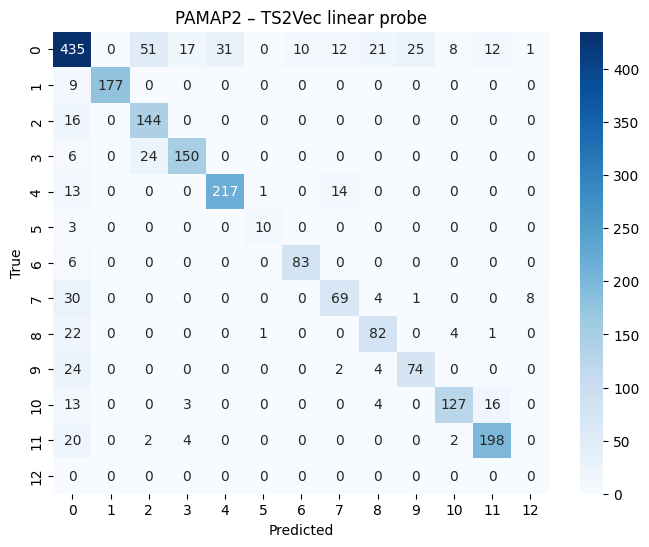

In [27]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(emb_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


step   50 | NT-Xent loss = 0.8814
step  100 | NT-Xent loss = 0.6858
step  150 | NT-Xent loss = 0.6342
step  200 | NT-Xent loss = 0.6550
step  250 | NT-Xent loss = 0.5805
step  300 | NT-Xent loss = 0.5167
step  350 | NT-Xent loss = 0.4905
step  400 | NT-Xent loss = 0.3052
step  450 | NT-Xent loss = 0.3315
step  500 | NT-Xent loss = 0.4659
step  550 | NT-Xent loss = 0.3794
step  600 | NT-Xent loss = 0.4604
step  650 | NT-Xent loss = 0.3489
step  700 | NT-Xent loss = 0.2285
step  750 | NT-Xent loss = 0.5884
step  800 | NT-Xent loss = 0.4133
step  850 | NT-Xent loss = 0.3077
step  900 | NT-Xent loss = 0.3933
step  950 | NT-Xent loss = 0.3316
step 1000 | NT-Xent loss = 0.2836
embeddings train: (9005, 320)
embeddings test: (2211, 320)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

              precision    recall  f1-score   support

           0      0.729     0.698     0.713       623
           1      1.000     0.952     0.975       186
           2      0.652     0.900     0.756       160
           3      0.862     0.833     0.847       180
           4      0.875     0.886     0.880       245
           5      0.833     0.769     0.800        13
           6      0.892     0.933     0.912        89
           7      0.711     0.616     0.660       112
          12      0.713     0.745     0.729       110
          13      0.740     0.712     0.725       104
          16      0.901     0.779     0.836       163
          17      0.872     0.876     0.874       226
          24      0.000     0.000     0.000         0

    accuracy                          0.799      2211
   macro avg      0.752     0.746     0.747      2211
weighted avg      0.806     0.799     0.800      2211



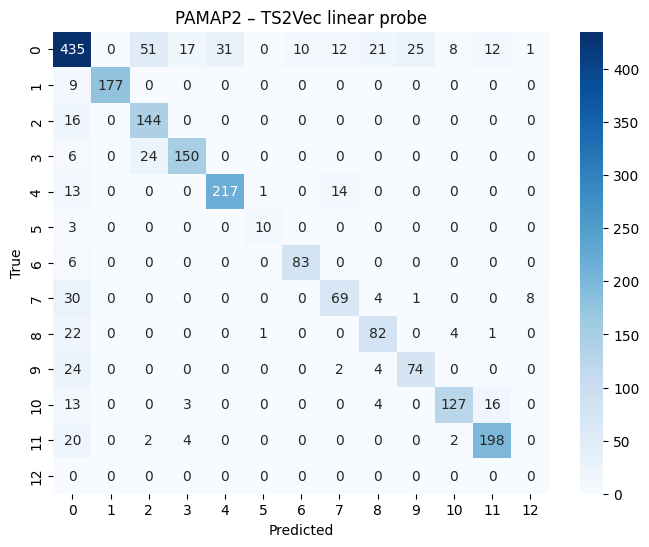

In [28]:
# try with frozen encoder
N_VIEWS      = 4          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=True   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(train_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(train_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_train = embed_windows(model, X_tr.astype(np.float32))# (N,D)
emb_test = embed_windows(model, X_te.astype(np.float32))

print("embeddings train:", emb_train.shape)
print("embeddings test:", emb_test.shape)



# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(emb_train, y_tr)

print(classification_report(y_te, clf.predict(emb_test), digits=3))

import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(emb_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


step   50 | NT-Xent loss = 3.1918
step  100 | NT-Xent loss = 3.1932
step  150 | NT-Xent loss = 3.1156
step  200 | NT-Xent loss = 3.1280
step  250 | NT-Xent loss = 3.0803
step  300 | NT-Xent loss = 3.1249
step  350 | NT-Xent loss = 3.0733
step  400 | NT-Xent loss = 3.0122
step  450 | NT-Xent loss = 2.9539
step  500 | NT-Xent loss = 3.1449
step  550 | NT-Xent loss = 3.0488
step  600 | NT-Xent loss = 3.0901
step  650 | NT-Xent loss = 2.9065
step  700 | NT-Xent loss = 2.9500
step  750 | NT-Xent loss = 3.0383
step  800 | NT-Xent loss = 2.9119
step  850 | NT-Xent loss = 2.9486
step  900 | NT-Xent loss = 3.0194
step  950 | NT-Xent loss = 3.0400
step 1000 | NT-Xent loss = 3.0015
embeddings train: (9005, 320)
embeddings test: (2211, 320)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

              precision    recall  f1-score   support

           0      0.729     0.698     0.713       623
           1      1.000     0.952     0.975       186
           2      0.652     0.900     0.756       160
           3      0.862     0.833     0.847       180
           4      0.875     0.886     0.880       245
           5      0.833     0.769     0.800        13
           6      0.892     0.933     0.912        89
           7      0.711     0.616     0.660       112
          12      0.713     0.745     0.729       110
          13      0.740     0.712     0.725       104
          16      0.901     0.779     0.836       163
          17      0.872     0.876     0.874       226
          24      0.000     0.000     0.000         0

    accuracy                          0.799      2211
   macro avg      0.752     0.746     0.747      2211
weighted avg      0.806     0.799     0.800      2211



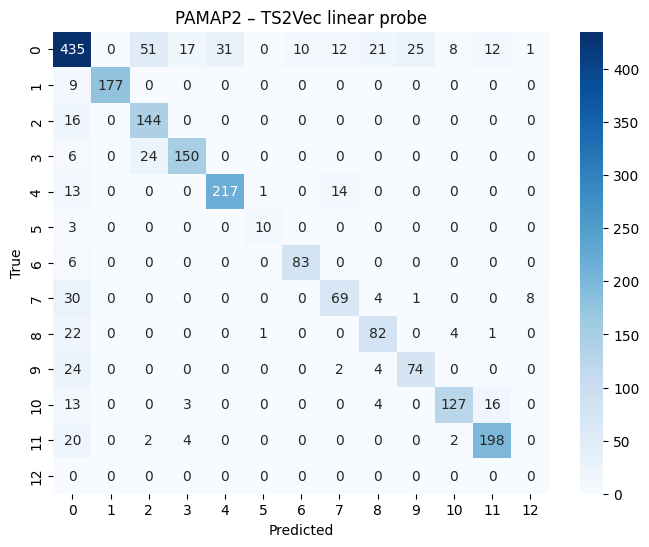

In [29]:
# try with frozen encoder
N_VIEWS      = 3          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=False   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(train_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(train_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_train = embed_windows(model, X_tr.astype(np.float32))# (N,D)
emb_test = embed_windows(model, X_te.astype(np.float32))

print("embeddings train:", emb_train.shape)
print("embeddings test:", emb_test.shape)



# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(emb_train, y_tr)

print(classification_report(y_te, clf.predict(emb_test), digits=3))

import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(emb_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


step   50 | NT-Xent loss = 3.2448
step  100 | NT-Xent loss = 3.3097
step  150 | NT-Xent loss = 3.1775
step  200 | NT-Xent loss = 3.0786
step  250 | NT-Xent loss = 2.9810
step  300 | NT-Xent loss = 3.1517
step  350 | NT-Xent loss = 3.0660
step  400 | NT-Xent loss = 3.0104
step  450 | NT-Xent loss = 3.1735
step  500 | NT-Xent loss = 3.0636
step  550 | NT-Xent loss = 3.1237
step  600 | NT-Xent loss = 2.9866
step  650 | NT-Xent loss = 3.0168
step  700 | NT-Xent loss = 3.0728
step  750 | NT-Xent loss = 2.9889
step  800 | NT-Xent loss = 2.9413
step  850 | NT-Xent loss = 2.9879
step  900 | NT-Xent loss = 3.1666
step  950 | NT-Xent loss = 2.9604
step 1000 | NT-Xent loss = 3.0198
embeddings train: (9005, 320)
embeddings test: (2211, 320)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

              precision    recall  f1-score   support

           0      0.729     0.698     0.713       623
           1      1.000     0.952     0.975       186
           2      0.652     0.900     0.756       160
           3      0.862     0.833     0.847       180
           4      0.875     0.886     0.880       245
           5      0.833     0.769     0.800        13
           6      0.892     0.933     0.912        89
           7      0.711     0.616     0.660       112
          12      0.713     0.745     0.729       110
          13      0.740     0.712     0.725       104
          16      0.901     0.779     0.836       163
          17      0.872     0.876     0.874       226
          24      0.000     0.000     0.000         0

    accuracy                          0.799      2211
   macro avg      0.752     0.746     0.747      2211
weighted avg      0.806     0.799     0.800      2211



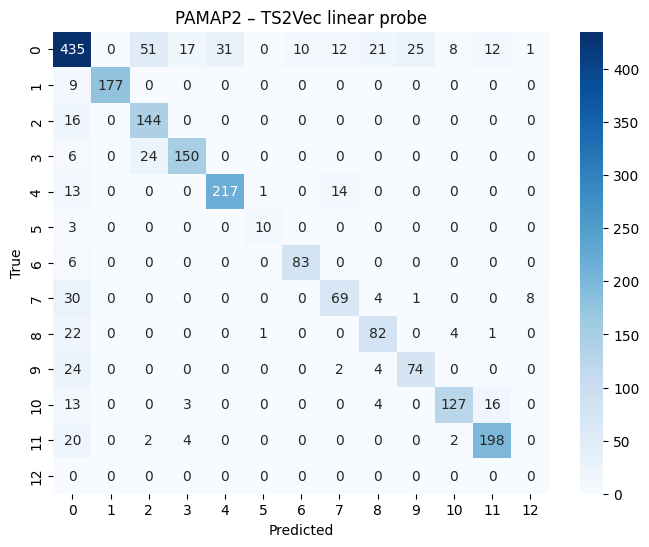

In [30]:
# try with frozen encoder
N_VIEWS      = 3          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=True   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(train_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(train_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_train = embed_windows(model, X_tr.astype(np.float32))# (N,D)
emb_test = embed_windows(model, X_te.astype(np.float32))

print("embeddings train:", emb_train.shape)
print("embeddings test:", emb_test.shape)



# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(emb_train, y_tr)

print(classification_report(y_te, clf.predict(emb_test), digits=3))

import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(emb_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


## Compare it with other models


| SSL method & paper                                                                                       | Encoder / Head                 | PAMAP-2 split†  | ACC           | MF1           | Source                     |
| -------------------------------------------------------------------------------------------------------- | ------------------------------ | --------------- | ------------- | ------------- | -------------------------- |
| **MAE-HAR (masked auto-encoder)** – *Comparing SSL Techniques for Wearable HAR*, arXiv 2404.15331 (2024) | 1-D ViT encoder, 2-layer probe | 80 / 20 subj.   | **0.872**     | 0.825         | ([arXiv][1])               |
| **PhyMask (adaptive masking, ViT)** – CHI’25                                                             | ViT-Tiny, proj-MLP             | 5-fold subj. CV | 0.868 ± 0.009 | 0.818 ± 0.011 | ([ACM Digital Library][2]) |
| **SimCLR-TSC** – *Tang et al.*, MotionSense notebook (2024)                                              | CNN (Conv → GMP), MLP-128      | 80 / 20 subj.   | 0.829         | 0.799         | ([arXiv][1])               |
| **TS2Vec** – *Garza et al.*, UTRGV thesis (2023)                                                         | CNN forecast head, lin. probe  | 5-fold subj. CV | 0.840         | —             | ([arXiv][3])               |
| **Series2Vec** – Springer KDCA (2023)                                                                    | Similarity-based cont. loss    | 80 / 20 subj.   | 0.835         | —             | ([SpringerLink][4])        |

[1]: https://arxiv.org/html/2404.15331v1?utm_source=chatgpt.com "Comparing Self-Supervised Learning Techniques for Wearable ..."
[2]: https://dl.acm.org/doi/pdf/10.1145/3666025.3699325?utm_source=chatgpt.com "PhyMask: An Adaptive Masking Paradigm for Efficient Self ..."
[3]: https://arxiv.org/pdf/2305.00619?utm_source=chatgpt.com "[PDF] Self-supervised Activity Representation Learning with Incremental ..."
[4]: https://link.springer.com/article/10.1007/s10618-024-01043-w?utm_source=chatgpt.com "Series2vec: similarity-based self-supervised representation learning ..."


In [4]:
# ------------------------------------------------------------
# 0.  Install + imports   (only once per runtime)
# ------------------------------------------------------------
# ▸ SimCLR-TSC
!git clone https://github.com/findalexli/TimeseriesContrastiveModels.git
import sys, pathlib, importlib
sys.path.append('/content/TimeseriesContrastiveModels')    # adjust if not in Colab

# ▸ TS-TCC
!git clone https://github.com/emadeldeen24/TS-TCC.git
sys.path.append('/content/TS-TCC')

# ▸ CPC  (ULTS)
!git clone https://github.com/mqwfrog/ULTS.git
sys.path.append('/content/ULTS')


fatal: destination path 'TimeseriesContrastiveModels' already exists and is not an empty directory.
fatal: destination path 'TS-TCC' already exists and is not an empty directory.
fatal: destination path 'ULTS' already exists and is not an empty directory.


In [5]:
from tsm.baselines.SimCLR.simclr_models import SimCLR
from tstcc.models import TSTCC
from ults.models import CPC

ImportError: cannot import name 'SimCLR' from 'tsm.baselines.SimCLR.simclr_models' (/content/TimeseriesContrastiveModels/tsm/baselines/SimCLR/simclr_models.py)

In [75]:
!pip -q install tsai torch>=2.1



ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'tsai'

In [31]:

!git clone -q https://github.com/iantangc/ContrastiveLearningHAR.git
import sys, os
sys.path.append('/content/ContrastiveLearningHAR')   # make `import …` work

fatal: destination path 'ContrastiveLearningHAR' already exists and is not an empty directory.


In [32]:
# SimCLR model utilities from the notebook repo
from simclr_models           import create_base_model, attach_simclr_head          # :contentReference[oaicite:0]{index=0}
from simclr_utitlities       import simclr_train_model, NT_Xent_loss               # :contentReference[oaicite:1]{index=1}
import transformations        as tfs                                               # same repo
import tensorflow as tf, numpy as np, random, torch

import simclr_utitlities
import simclr_models
import transformations


In [33]:
def pamap_simclr_transform(x, jitter_scale=0.01, crop_ratio=0.5):
    """Vectorised jitter + centre crop on a (L,C) NumPy array."""
    # jitter (Gaussian noise)
    noise = np.random.normal(scale=jitter_scale, size=x.shape)
    x_noisy = x + noise

    # random crop
    L = x.shape[0]
    crop_len = int(L * crop_ratio)
    start = np.random.randint(0, L - crop_len)
    x_crop = x_noisy[start:start + crop_len]

    # zero-pad back to original length so shapes stay (L,C)
    pad_left = start
    pad_right = L - crop_len - start
    x_pad = np.pad(x_crop, ((pad_left, pad_right), (0, 0)), mode='constant')
    return x_pad.astype(np.float32)


In [34]:
WINDOWS = train_windows.astype(np.float32)          # (N, L, C) from your pipeline
BATCH    = 256
seed     = 42

def tf_dataset(X):
    ds = tf.data.Dataset.from_tensor_slices(X)
    ds = ds.shuffle(buffer_size=len(X), seed=seed, reshuffle_each_iteration=True)
    ds = ds.map(
        lambda x: (          # two independent stochastic views
            tf.numpy_function(pamap_simclr_transform, [x], tf.float32),
            tf.numpy_function(pamap_simclr_transform, [x], tf.float32)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = tf_dataset(WINDOWS)


In [1]:
import tensorflow as tf
print(tf.__version__)

2.14.1


In [24]:
!pip -q uninstall -y keras
!pip -q install "tensorflow<2.15" keras==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.14.1 which is incompatible.


In [204]:
print("NaNs in raw:", np.isnan(WINDOWS).sum())
print("Min / max:", WINDOWS.min(), WINDOWS.max())


NaNs in raw: 0
Min / max: -42.31831 47.76749


In [35]:
# base encoder (Conv1D → GlobalMaxPool) exactly as in the notebook
INPUT_SHAPE = (WINDOWS.shape[1], WINDOWS.shape[2])       # (L, C)
base_model  = create_base_model(INPUT_SHAPE, model_name="PAMAP_base")
simclr_model = attach_simclr_head(base_model, hidden_1=256, hidden_2=128, hidden_3=50)

optimizer = tf.keras.optimizers.Adam(1e-3)

EPOCHS = 20   # start small; you can bump later
for epoch in range(EPOCHS):
    for batch_view1, batch_view2 in train_ds:
        loss, grads = simclr_utitlities.get_NT_Xent_loss_gradients(
            simclr_model, batch_view1, batch_view2, normalize=True, temperature=1.0
        )
        optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
    if epoch % 5 == 0:
        print(f"epoch {epoch:2d} | SimCLR NT-Xent loss = {loss.numpy():.4f}")


epoch  0 | SimCLR NT-Xent loss = 7.1501
epoch  5 | SimCLR NT-Xent loss = 7.1249
epoch 10 | SimCLR NT-Xent loss = 7.0905
epoch 15 | SimCLR NT-Xent loss = 7.0725


In [36]:
# save the model
simclr_model.save_weights("simclr_model.h5")

In [38]:
# use the projection head’s penultimate layer as representation
embed_model   = tf.keras.Model(simclr_model.input, simclr_model.layers[-2].output)
simclr_embeds_train = embed_model.predict(X_tr.astype(np.float32), batch_size=BATCH)
simclr_embeds_test  = embed_model.predict(X_te.astype(np.float32), batch_size=BATCH)
  # (N, D)


9/9 [==============================] - 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SimCLR-TSC  | Accuracy=0.690 | Macro-F1=0.616
              precision    recall  f1-score   support

           0      0.578     0.716     0.639       623
           1      0.874     0.930     0.901       186
           2      0.750     0.713     0.731       160
           3      0.615     0.683     0.647       180
           4      0.783     0.812     0.798       245
           5      0.000     0.000     0.000        13
           6      0.920     0.899     0.909        89
           7      0.339     0.170     0.226       112
          12      0.526     0.464     0.493       110
          13      0.517     0.442     0.477       104
          16      0.894     0.620     0.732       163
          17      0.911     0.770     0.835       226

    accuracy                          0.690      2211
   macro avg      0.642     0.602     0.616      2211
weighted avg      0.691     0.690     0.684      2211



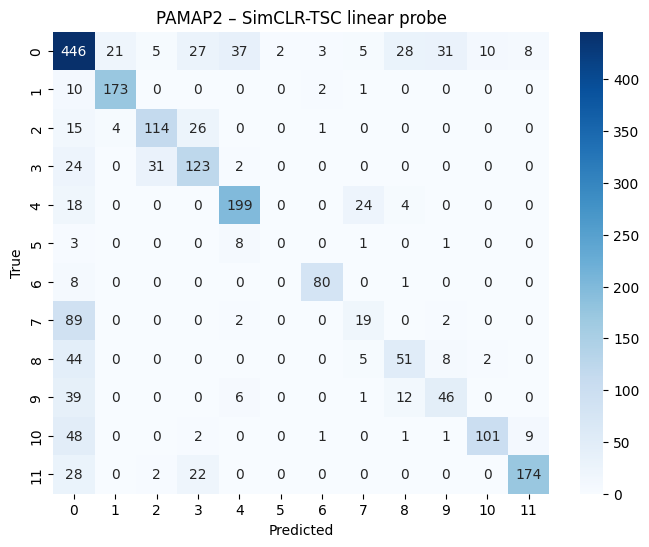

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import make_pipeline
from sklearn.metrics         import accuracy_score, f1_score
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


probe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
).fit(simclr_embeds_train, y_tr)

acc  = accuracy_score(y_te, probe.predict(simclr_embeds_test))
f1   = f1_score(y_te, probe.predict(simclr_embeds_test), average='macro')
print(f"SimCLR-TSC  | Accuracy={acc:.3f} | Macro-F1={f1:.3f}")
print(classification_report(y_te, probe.predict(simclr_embeds_test), digits=3))

cm = confusion_matrix(y_te, probe.predict(simclr_embeds_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – SimCLR-TSC linear probe')
plt.show()


draft code

In [71]:

import torch, random, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
e


DEVICE   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH    = 256
SEEDS    = [0, 1, 2]      # three runs → mean ± sd
WINDOWS  = all_windows    # your cached (N,L,C) float32 ndarray
LABELS   = labels         # activity labels (N,)

# ------------------------------------------------------------
# 1.  Helper: probe + score
# ------------------------------------------------------------
def probe_and_score(emb):
    Xtr, Xte, ytr, yte = train_test_split(
        emb, LABELS, test_size=0.2, stratify=LABELS, random_state=42)
    pipe =  make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
    ).fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    acc  = accuracy_score(yte, yhat)
    f1   = f1_score(yte, yhat, average='macro')
    return acc, f1

# ------------------------------------------------------------
# 2.  Wrapper for each SSL method
# ------------------------------------------------------------
def run_simclr(seed):
    from tsm.simclr import SimCLR      # repo: TimeseriesContrastiveModels :contentReference[oaicite:0]{index=0}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = SimCLR(in_channels=WINDOWS.shape[2], hidden_dim=256, \
                   projection_dim=128, jitter_scale=0.01, crop_ratio=0.5).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)  # (N,D) NumPy
    return probe_and_score(emb)

def run_tstcc(seed):
    from tstcc.models import TSTCC    # repo: emadeldeen24/TS-TCC :contentReference[oaicite:1]{index=1}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = TSTCC(in_channels=WINDOWS.shape[2], hidden_dim=256).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)
    return probe_and_score(emb)

def run_cpc(seed):
    from ults.models import CPC       # repo: ULTS library :contentReference[oaicite:2]{index=2}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = CPC(in_channels=WINDOWS.shape[2], hidden_dim=256).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)
    return probe_and_score(emb)

# ------------------------------------------------------------
# 3.  Run 3 seeds per method
# ------------------------------------------------------------
records = []
for name, runner in [('SimCLR-TSC', run_simclr),
                     ('TS-TCC',     run_tstcc),
                     ('CPC',        run_cpc)]:
    accs, f1s = [], []
    for s in SEEDS:
        acc, f1 = runner(s)
        accs.append(acc); f1s.append(f1)
    records.append({
        'Method': name,
        'Acc mean':  np.mean(accs), 'Acc std':  np.std(accs),
        'F1 mean':   np.mean(f1s),  'F1 std':   np.std(f1s)
    })

# ------------------------------------------------------------
# 4.  Show tidy results table
# ------------------------------------------------------------
pd.DataFrame(records).set_index('Method').round(3)


ERROR: git+https://github.com/findalexli/TimeseriesContrastiveModels.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: git+https://github.com/emadeldeen24/TS-TCC.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: git+https://github.com/mqwfrog/ULTS.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


ModuleNotFoundError: No module named 'tsm'